In [1]:
from tensorflow.keras.models import Sequential

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, GlobalAveragePooling2D

In [4]:
from tensorflow.keras.optimizers import Adam

In [5]:
from tensorflow.data import AUTOTUNE

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
from matplotlib import pyplot as plt

In [8]:
from tensorflow.keras.regularizers import l2

In [9]:
import tensorflow as tf

In [10]:
import numpy as np

In [11]:
from tqdm import tqdm

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
train_ds = image_dataset_from_directory(
    directory = r'dataset\train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (168, 168),
    shuffle=True
)

Found 4216 files belonging to 2 classes.


In [15]:
valid_ds = image_dataset_from_directory(
    directory = r'dataset\validation',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (168, 168),
    shuffle=True
)

Found 736 files belonging to 2 classes.


In [16]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
# data_augmentation = Sequential([
#     layers.RandomBrightness(factor=0.1),  # change brightness slightly
#     layers.RandomContrast(factor=0.1),    # adjust contrast slightly
#     layers.GaussianNoise(0.01),           # simulate background noise
# ])

In [18]:
# data_augmentation

In [19]:
train_ds.class_names


['gunshot', 'non_gunshot']

In [20]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))


In [21]:
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
# valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(168, 168, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(MaxPooling2D())
# model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(MaxPooling2D())
# model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(MaxPooling2D())
# model.add(Dropout(0.3))


In [24]:
model.add(Flatten())

In [25]:
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 166, 166, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 83, 83, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 81, 81, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 38, 38, 128)      5

In [27]:
adam = Adam(learning_rate=1e-6)

In [28]:
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
earlystopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights=True,
    mode='max',
)

In [30]:
x_list = []
y_list = []

for images, labels in tqdm(train_ds, desc="Converting train_ds to NumPy"):
    x_list.append(images.numpy())
    y_list.append(labels.numpy())

X = np.concatenate(x_list, axis=0)
y = np.concatenate(y_list, axis=0)


Converting train_ds to NumPy: 100%|██████████████████████████████████████████████████| 132/132 [00:09<00:00, 14.48it/s]


In [31]:
len(X)

4216

In [32]:
X = np.array([x.astype(np.float32) for x in tqdm(X, desc="Converting X")])

y = np.array([int(label) for label in tqdm(y, desc="Converting y")])


Converting X: 100%|██████████████████████████████████████████████████████████████| 4216/4216 [00:01<00:00, 2980.60it/s]

KeyboardInterrupt



In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)


In [ ]:
checkpoint = ModelCheckpoint(
    filepath=r"model\gunshot_model_epoch_{epoch:02d}_acc_{accuracy:.2f}_valacc_{val_accuracy:.2f}.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)

In [ ]:
import tensorflow as tf

with tf.device('/CPU:0'):
    history = model.fit(X, y, epochs=10, batch_size=32, validation_data=valid_ds, callbacks=[earlystopping, checkpoint])


Epoch 1/10
 45/132 [=========>....................] - ETA: 2:30 - loss: 0.8325 - accuracy: 0.5757

In [127]:
history = model.fit(X_train, y_train, epochs=10, batch_size=None, callbacks=[earlystopping], validation_data=valid_ds)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

# Accuracy

In [ ]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.show

# Loss

In [ ]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

# Saving Model

In [ ]:
import tensorflow as tf
tf.saved_model.save(model, "gunshot_model")


In [ ]:
model = tf.saved_model.load("gunshot_model")

In [ ]:
model.save('model.h5', save_format='h5')

# Demo

In [2]:
import librosa
import librosa.display

In [3]:
from matplotlib import pyplot as plt

In [4]:
import numpy as np

In [5]:
import tensorflow as tf

In [18]:
from tensorflow.keras.models import load_model
model = load_model("gunshot_model_epoch_05_acc_0.90_valacc_0.96.h5") 

In [7]:
def audio_to_melspectrogram(audio_path, fixed_length=168):
    """Extract Mel Spectrogram with a consistent shape (168, 168)."""
    try:
        audio, sr = librosa.load(audio_path, sr=22050, mono=True)
        n_fft = min(2048, len(audio))  # Ensure valid n_fft

        # **Extract Log-Mel Spectrogram**
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio, sr=sr, n_fft=n_fft, n_mels=168, fmax=8000
        )
        mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # **Fix shape to (168, 168)**
        if mel_db.shape[1] > fixed_length:
            mel_db = mel_db[:, :fixed_length]  # Trim
        else:
            mel_db = np.pad(mel_db, ((0, 0), (0, fixed_length - mel_db.shape[1])), mode='constant')  # Pad

        return mel_db  # Return spectrogram only

    except Exception as e:
        print(f"❌ Error processing {audio_path}: {e}")
        return None  # Handle errors gracefully

In [42]:
def save_spectrogram(mel_spec, save_path):
    plt.figure(figsize=(5,5))
    librosa.display.specshow(mel_spec, x_axis='time', y_axis="mel")
    plt.axis('off') # remove axis
    plt.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close()

In [62]:
mel_spec = audio_to_melspectrogram(r"F:\camera\gun shot\demo.wav")

In [63]:
save_spectrogram(mel_spec, '1.png')

In [64]:
from PIL import Image


In [65]:
img = Image.open('1.png')

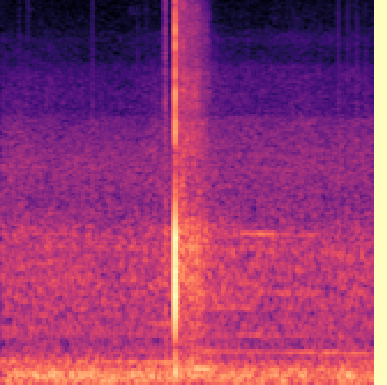

In [66]:
img

In [67]:
img_array = np.array(img).astype("float32") / 255.0  # scale if needed
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension for prediction


In [68]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Load image and convert to RGB
img = Image.open("1.png").convert("RGB").resize((168, 168))
img_array = np.array(img).astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)


In [69]:
model = tf.keras.models.load_model("gunshot_model_epoch_05_acc_0.90_valacc_0.96.h5")
output = model.predict(img_array)  # or img_tensor
predicted_label = (output > 0.6).astype(int)  # Output: [[1]]
if predicted_label[0][0] == 1:
     print(f"No Shot: {output}")
else:
    print(f"Shot: {output}")


1/1 [==============================] - 0s 174ms/step
Shot: [[0.05633572]]


In [70]:
[[0.522141]]   gun
 [0.46422383]] 

SyntaxError: unmatched ']' (1019159067.py, line 2)

In [83]:
import sounddevice as sd
import numpy as np
import librosa
import tensorflow as tf
import time

# Load the model
model = tf.keras.models.load_model("gunshot_model_epoch_05_acc_0.90_valacc_0.96.h5")

# Parameters
SAMPLE_RATE = 22050
DURATION = 1  # seconds
CHUNK_SIZE = SAMPLE_RATE * DURATION
THRESHOLD = 0.6  # confidence threshold

def audio_callback(indata, frames, time, status):
    if status:
        print(status)
    audio = indata[:, 0]

    mel = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Convert (H, W) → (H, W, 3)
    mel_db = np.stack([mel_db]*3, axis=-1)
    mel_db = tf.image.resize(mel_db, (168, 168)).numpy()

    # Add batch dimension
    mel_db = np.expand_dims(mel_db, axis=0)

    # Predict
    pred = model.predict(mel_db)[0][0]
    if pred > THRESHOLD:
        print(f"✅ No gunshot. Confidence: {pred:.2f}")
        
    else:
        print(f"🔫 Gunshot Detected! Confidence: {pred:.2f}")
        

# Start streaming
with sd.InputStream(callback=audio_callback, channels=1, samplerate=SAMPLE_RATE, blocksize=CHUNK_SIZE):
    print("🎤 Listening for gunshots... Press Ctrl+C to stop.")
    while True:
        time.sleep(0.1)


🎤 Listening for gunshots... Press Ctrl+C to stop.
1/1 [==============================] - 0s 75ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 20ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 22ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 21ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 29ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 24ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 21ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 26ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 25ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 27ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] - 0s 30ms/step
✅ No gunshot. Confidence: 1.00
1/1 [==============================] 

KeyboardInterrupt: 